# Sentiment Analysis on Movie Reviews
This dataset contains two columns: review and sentiment. The review column includes text data **(movie reviews)**, and the sentiment column labels each review as either `"positive"` or `"negative."` The main aim is to develop a model that can predict positive or negative reviews of different movie sentiments.

## Import Libraries
Import all necessary libraries to be used in the analysis process.

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.tree import Tree
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import preprocessing

# Download necessary NLTK resources

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

### Load the dataset

In [2]:
movie_df = pd.read_csv('/content/IMDB Dataset.csv')

In [3]:
movie_df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


## Quick overview of the data

In [4]:
print(movie_df.isnull().sum())

review       0
sentiment    0
dtype: int64


In [5]:
movie_df.dtypes

,0
review,object
sentiment,object


## Visualize the Distribution of Reviews (Positive vs. Negative)
This step visualizes how many reviews are positive and how many are negative.

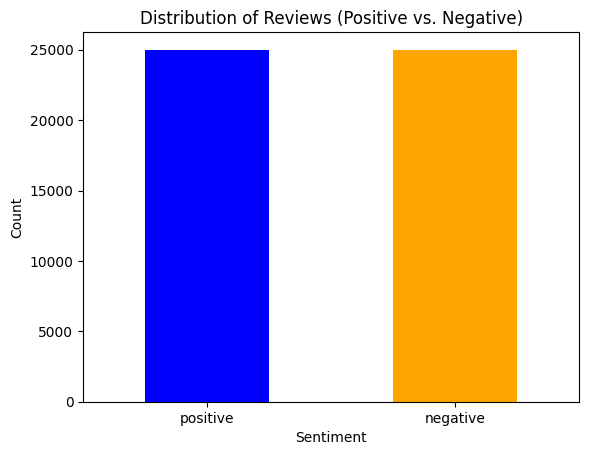

In [6]:
movie_df['sentiment'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of Reviews (Positive vs. Negative)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Step 1: Text Preprocessing

### Remove named entities (NER)
Named entities(e.g., names of people, places) which may not contribute to meaningful classification are removed.

In [7]:
import nltk
from nltk.tokenize import word_tokenize
from nltk import ne_chunk, pos_tag

# Function to remove named entities
def remove_named_entities(text):
    # Tokenization and Part-of-Speech tagging
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)

    # Named Entity Recognition
    named_entities = ne_chunk(pos_tags)

    # Remove named entities by skipping chunks that represent entities
    cleaned_tokens = []
    for chunk in named_entities:
        if isinstance(chunk, nltk.Tree):  # If it's a named entity
            entity_label = chunk.label()
            if entity_label not in ['PERSON', 'ORGANIZATION', 'GPE']:  # Skip these entity types
                # If it's not a target entity, add the tokens back
                cleaned_tokens.extend([token for token, pos in chunk.leaves()])
        else:
            # If it's not a named entity, add the token back
            token, pos = chunk
            cleaned_tokens.append(token)

    # Join tokens back into a string
    return ' '.join(cleaned_tokens)

# Apply the function to the DataFrame
movie_df['cleaned_review'] = movie_df['review'].apply(remove_named_entities)

# Display the results
movie_df.head(5)


,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,One of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,A wonderful little production . < br / > < br ...
2,I thought this was a wonderful way to spend ti...,positive,I thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,Basically there 's a family where a little boy...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,'s `` Love in the Time of '' is a visually stu...


### Convert all text to lowercase

This ensures that all text is uniform (e.g., "Great" and "great" are treated the same).

In [8]:
movie_df['cleaned_review'] = movie_df['cleaned_review'].str.lower()

In [9]:
movie_df.head(5)

,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production . < br / > < br ...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,basically there 's a family where a little boy...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,'s `` love in the time of '' is a visually stu...



### Remove HTML tags from text in the dataset

In [10]:
from bs4 import BeautifulSoup

def remove_html(text):
    if isinstance(text, str):
        # Remove HTML using BeautifulSoup
        clean_text = BeautifulSoup(text, "html.parser").get_text()

        # Remove any unwanted characters (like remaining HTML artifacts) using regex
        clean_text = re.sub(r'\s+', ' ', clean_text)  # Remove excessive whitespace
        clean_text = re.sub(r'[^\w\s]', '', clean_text)  # Remove punctuation except word characters and spaces

        return clean_text.lower()  # Convert to lowercase
    return text

# Apply the function to the cleaned_review column
movie_df['cleaned_review'] = movie_df['cleaned_review'].apply(remove_html)

# Display the first few rows to verify changes
movie_df.head(5)


<ipython-input-10-629d2d62e015>:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  clean_text = BeautifulSoup(text, "html.parser").get_text()


,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production br br the...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,basically there s a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,s love in the time of is a visually stunning...


### Remove URLs, measurements, numbers, filler words, special characters, and punctuation

### Remove URLs
URLs are not useful for sentiment analysis thus removing them ensures the dataset is cleaner

In [11]:
def remove_urls(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

movie_df['cleaned_review'] = movie_df['cleaned_review'].apply(remove_urls)
movie_df.head(5)

,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production br br the...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,basically there s a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,s love in the time of is a visually stunning...


### Remove both numerical and written numbers

This ensures that the numbers do not interfere with the text-based analysis.

In [12]:
def remove_numbers(text):
    text = re.sub(r'\b\d+\b', '', text)  # Remove numerical digits
    text = re.sub(r'\b(one|two|three|four|five|six|seven|eight|nine|ten)\b', '', text)  # Remove written numbers
    return text

movie_df['cleaned_review'] = movie_df['cleaned_review'].apply(remove_numbers)
movie_df.head(5)

,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,of the other reviewers has mentioned that aft...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production br br the...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,basically there s a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,s love in the time of is a visually stunning...


### Remove measurements
Irrelevant units of measurements that do not contribute to sentiment classification are removed.

In [13]:
def remove_measurements(text):
    # Regular expression to match measurements (e.g., numbers followed by units)
    # Example units: kg, meters, cm, lb, g, etc.
    pattern = r'\b\d+\.?\d*\s?(kg|cm|meter|meters|mm|g|lb|oz|km|miles|inch|inches|feet|ft)\b'

    # Remove all measurements from the text
    cleaned_text = re.sub(pattern, '', text, flags=re.IGNORECASE)

    return cleaned_text

movie_df['cleaned_review'] = movie_df['cleaned_review'].apply(remove_measurements)
movie_df.head(5)

,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,of the other reviewers has mentioned that aft...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production br br the...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,basically there s a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,s love in the time of is a visually stunning...


### **Remove Emojis**
This ensures that reviews do not contain emojis or smileys that could interfere with accurate text processing and analysis.

In [14]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 8.6 MB/s eta 0:00:00


In [15]:
import emoji

def remove_emojis(text):
    return emoji.replace_emoji(text, replace='')

movie_df['cleaned_review'] = movie_df['cleaned_review'].apply(remove_emojis)
movie_df.head(5)


,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,of the other reviewers has mentioned that aft...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production br br the...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,basically there s a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,s love in the time of is a visually stunning...


### **Remove Filler Words**

In [16]:
# Define a list of filler words to remove
filler_words = [
    "uh", "um", "er", "probably", "you know", "I mean", "well", "so", "like", "basically",
    "actually", "seriously", "really", "just", "sort of", "kind of", "whatever",
    "honestly", "literally", "right", "yeah", "okay", "alright"
]

# Create a regex pattern from the list of filler words
filler_pattern = r'\b(?:' + '|'.join(filler_words) + r')\b'

# Define a function to remove filler words
def remove_filler_words(text):
    # Substitute filler words with an empty string
    cleaned_text = re.sub(filler_pattern, '', text, flags=re.IGNORECASE)
    # Remove extra spaces left after removing filler words
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    return cleaned_text

# Apply the function to the text data
movie_df['cleaned_review'] = movie_df['cleaned_review'].apply(remove_filler_words)

# Show the original and cleaned reviews
movie_df.head(5)



,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,of the other reviewers has mentioned that afte...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production br br the filmin...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,there s a family where a little boy thinks the...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,s love in the time of is a visually stunning f...


### Remove special characters and punctuation

In [17]:
import string

def remove_special_chars(text):
    # Remove all punctuation and special characters except letters and numbers
    return re.sub(r'[{}]'.format(re.escape(string.punctuation)), '', text)

# Apply the function to the review column
movie_df['cleaned_review'] = movie_df['cleaned_review'].apply(remove_special_chars)
movie_df.head(5)


,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,of the other reviewers has mentioned that afte...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production br br the filmin...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,there s a family where a little boy thinks the...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,s love in the time of is a visually stunning f...


In [18]:
import string

def remove_special_chars(text):
    # Remove all punctuation and special characters except letters and numbers
    return re.sub(r'[{}]'.format(re.escape(string.punctuation)), '', text)

# Apply the function to the review column
movie_df['cleaned_review'] = movie_df['cleaned_review'].apply(remove_special_chars)
movie_df.head(5)

,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,of the other reviewers has mentioned that afte...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production br br the filmin...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,there s a family where a little boy thinks the...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,s love in the time of is a visually stunning f...


### Tokenization and Removal of Stop Words

In [20]:
def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    additional_stop_words = [
    'movie', 'film', 'one', 'like', 'story', 'character', 'characters', 'just',
    'time', 'really', 'get', 'good', 'much', 'even', 'make', 'way', 'well',
    'first', 'see', 'two', 'also', 'would', 'could', 'many', 'people'
]
    stop_words = stop_words.union(set(additional_stop_words))
    clean_text = ' '.join([word for word in text.split() if word.lower() not in stop_words])
    return clean_text
movie_df['cleaned_review'] = movie_df['cleaned_review'].apply(remove_stop_words)

def tokenize_text(text):
    return word_tokenize(text)
movie_df['tokens'] = movie_df['cleaned_review'].apply(tokenize_text)
movie_df.head()

,review,sentiment,cleaned_review,tokens
0,One of the other reviewers has mentioned that ...,positive,reviewers mentioned watching oz episode hooked...,"[reviewers, mentioned, watching, oz, episode, ..."
1,A wonderful little production. <br /><br />The...,positive,wonderful little production br br filming tech...,"[wonderful, little, production, br, br, filmin..."
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful spend hot summer weekend sit...,"[thought, wonderful, spend, hot, summer, weeke..."
3,Basically there's a family where a little boy ...,negative,family little boy thinks zombie closet parents...,"[family, little, boy, thinks, zombie, closet, ..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,love visually stunning watch offers us vivid p...,"[love, visually, stunning, watch, offers, us, ..."


### Add Custom Stopwords

In [21]:
# Define custom stopwords for positive and negative reviews
positive_stopwords = ["amazing", "great", "excellent", "best", "wonderful", "awesome", "fantastic", "brilliant"]
negative_stopwords = ["terrible", "horrible", "awful", "worst", "bad", "boring", "disappointing", "poor"]

In [22]:
import nltk
from nltk.corpus import stopwords

# Download stopwords from NLTK if necessary
nltk.download('stopwords')

# Get NLTK's standard English stopwords
nltk_stopwords = set(stopwords.words('english'))

# Combine NLTK stopwords with custom stopwords for good and bad reviews
positive_all_stopwords = nltk_stopwords.union(positive_stopwords)
negative_all_stopwords = nltk_stopwords.union(negative_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
# Define a function to remove links
def remove_links(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text)

# Define a function to remove stopwords based on sentiment
def remove_sentiment_stopwords(text, sentiment):
    words = text.split()
    if sentiment == 'positive':
        cleaned_text = ' '.join([word for word in words if word.lower() not in positive_all_stopwords])
    elif sentiment == 'negative':
        cleaned_text = ' '.join([word for word in words if word.lower() not in negative_all_stopwords])
    else:
        cleaned_text = text  # In case there is no sentiment label
    return cleaned_text


# Apply the cleaning functions (based on sentiment)
movie_df['review'] = movie_df.apply(lambda row: remove_sentiment_stopwords(remove_links(row['review']), row['sentiment']), axis=1)

# Show the cleaned reviews
movie_df[['review', 'cleaned_review', 'sentiment']].head()

,review,cleaned_review,sentiment
0,One reviewers mentioned watching 1 Oz episode ...,reviewers mentioned watching oz episode hooked...,positive
1,little production. <br /><br />The filming tec...,wonderful little production br br filming tech...,positive
2,"thought way spend time hot summer weekend, sit...",thought wonderful spend hot summer weekend sit...,positive
3,Basically there's family little boy (Jake) thi...,family little boy thinks zombie closet parents...,negative
4,"Petter Mattei's ""Love Time Money"" visually stu...",love visually stunning watch offers us vivid p...,positive


### Stemming

In [25]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

movie_df['tokens'] = movie_df['tokens'].apply(lambda x: [stemmer.stem(word) for word in x])

# Display the cleaned tokens
# Display the cleaned tokens
movie_df[['review', 'tokens']].head()

,review,tokens
0,One reviewers mentioned watching 1 Oz episode ...,"[review, mention, watch, oz, episod, hook, exa..."
1,little production. <br /><br />The filming tec...,"[wonder, littl, product, br, br, film, techniq..."
2,"thought way spend time hot summer weekend, sit...","[thought, wonder, spend, hot, summer, weekend,..."
3,Basically there's family little boy (Jake) thi...,"[famili, littl, boy, think, zombi, closet, par..."
4,"Petter Mattei's ""Love Time Money"" visually stu...","[love, visual, stun, watch, offer, us, vivid, ..."


In [26]:
movie_df.head(30)

,review,sentiment,cleaned_review,tokens
0,One reviewers mentioned watching 1 Oz episode ...,positive,reviewers mentioned watching oz episode hooked...,"[review, mention, watch, oz, episod, hook, exa..."
1,little production. <br /><br />The filming tec...,positive,wonderful little production br br filming tech...,"[wonder, littl, product, br, br, film, techniq..."
2,"thought way spend time hot summer weekend, sit...",positive,thought wonderful spend hot summer weekend sit...,"[thought, wonder, spend, hot, summer, weekend,..."
3,Basically there's family little boy (Jake) thi...,negative,family little boy thinks zombie closet parents...,"[famili, littl, boy, think, zombi, closet, par..."
4,"Petter Mattei's ""Love Time Money"" visually stu...",positive,love visually stunning watch offers us vivid p...,"[love, visual, stun, watch, offer, us, vivid, ..."
5,"Probably all-time favorite movie, story selfle...",positive,alltime favorite selflessness sacrifice dedica...,"[alltim, favorit, selfless, sacrif, dedic, nob..."
6,sure would like see resurrection dated Seahunt...,positive,sure resurrection dated seahunt series tech to...,"[sure, resurrect, date, seahunt, seri, tech, t..."
7,"show amazing, fresh & innovative idea 70's fir...",negative,show amazing fresh innovative idea aired years...,"[show, amaz, fresh, innov, idea, air, year, br..."
8,Encouraged positive comments film looking forw...,negative,encouraged positive comments looking forward w...,"[encourag, posit, comment, look, forward, watc..."
9,like original gut wrenching laughter like movi...,positive,original gut wrenching laughter young old love...,"[origin, gut, wrench, laughter, young, old, lo..."


<!-- #### Remove numbers -->

## Vectorization

### Convert Text into Numerical Format(TF-IDF vectorizer)

In [27]:
# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the reviews into a sparse matrix
tfidf_matrix = vectorizer.fit_transform(movie_df['cleaned_review'])

# Get feature names (words in the vocabulary)
feature_names = vectorizer.get_feature_names_out()

# Example: Get the TF-IDF scores for the first review
first_review_scores = tfidf_matrix[0]

# Convert the sparse matrix for the first review to a dictionary
# Using first_review_scores.toarray() would cause MemoryError, so we avoid that
importance_scores = {feature_names[i]: first_review_scores[0, i] for i in first_review_scores.nonzero()[1]}

# Print the TF-IDF scores for the first review
print(importance_scores)

{'reviewers': 0.07017299685967233, 'mentioned': 0.06088755044112881, 'watching': 0.07134562068053651, 'oz': 0.4493203593471164, 'episode': 0.10603821313828467, 'hooked': 0.07692518068705184, 'exactly': 0.05341785198436852, 'happened': 0.053146116105943414, 'br': 0.11395046372884174, 'thing': 0.03581731284957935, 'struck': 0.1545988972895609, 'brutality': 0.08567119351109678, 'unflinching': 0.10317181350143534, 'scenes': 0.03529342663672822, 'violence': 0.21830556554820763, 'set': 0.04400504261337657, 'word': 0.10941062761640896, 'trust': 0.06758369074425624, 'faint': 0.0924891838746598, 'hearted': 0.08605122033926131, 'timid': 0.09816436100644792, 'pulls': 0.07311016926576722, 'punches': 0.08654331322266792, 'regards': 0.08557798629564632, 'drugs': 0.06782392620914068, 'sex': 0.05057171655337347, 'hardcore': 0.0790850119903332, 'classic': 0.04723624287697198, 'use': 0.046559755407699424, 'called': 0.050132324617663364, 'nickname': 0.09816436100644792, 'given': 0.04646942342894761, 'sta

### Bag of Words(BoW)

The Bag of Words model is a way of representing text data where each unique word in the corpus is represented as a feature. The model doesn't consider grammar or word order, just the frequency of words in the text.

**Aim**: To convert the movie reviews into a numerical format by counting the frequency of words using the Bag of Words model.

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
# Initialize CountVectorizer (BoW)
vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the reviews to a BoW matrix (X)
X = vectorizer.fit_transform(movie_df['cleaned_review'])

# Define the target variable (y)
y = movie_df['sentiment']


### Word cloud
A Word Cloud visually represents the most frequent words in the text, where the size of each word indicates its frequency or importance.

**Aim**: To visualize the most frequent words in the movie reviews using a word cloud.

* CountVectorizer(): This function converts
the text into a bag of words model by counting the occurrences of each word.

* fit_transform(): This method is applied to fit the vectorizer on the text and transform it into a sparse matrix where each row corresponds to a document, and each column corresponds to a word.

* get_feature_names_out(): This retrieves the vocabulary (list of words) created by the vectorizer.

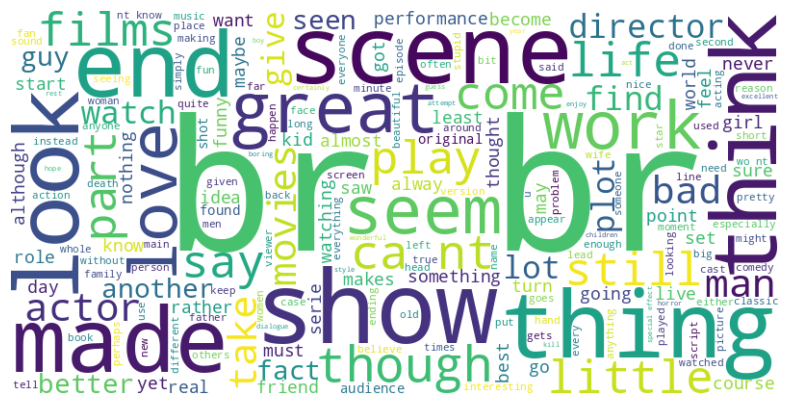

In [29]:
# pip install wordcloud matplotlib nltk pandas
# Import required libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join all the cleaned reviews into one large text
all_text = ' '.join(movie_df['cleaned_review'].tolist())

# Create the word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No axis to show
plt.show()

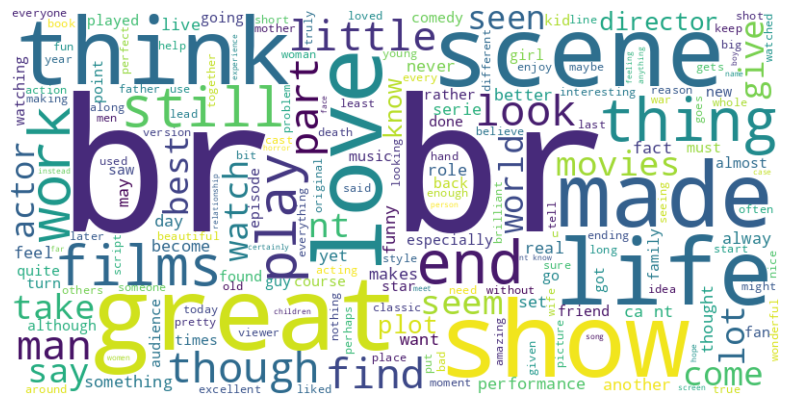

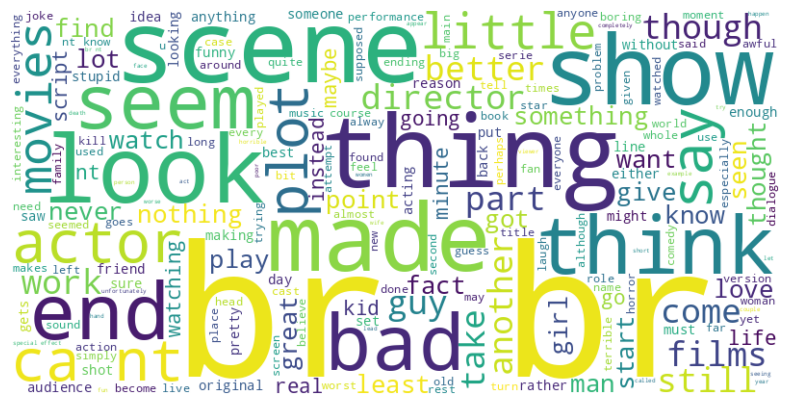

In [30]:
# Generate a word cloud for positive reviews
positive_reviews = ' '.join(movie_df[movie_df['sentiment'] == 'positive']['cleaned_review'].tolist())
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

# Plot the positive word cloud
plt.figure(figsize=(10, 5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Generate a word cloud for negative reviews
negative_reviews = ' '.join(movie_df[movie_df['sentiment'] == 'negative']['cleaned_review'].tolist())
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)

# Plot the negative word cloud
plt.figure(figsize=(10, 5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Convert sentiment to numerical values (binary: 1 for positive, 0 for negative)

In [31]:
y = pd.get_dummies(movie_df['sentiment'], drop_first=True).values.ravel()  # Positive = 1, Negative = 0

## Training

### Train-test split

In [32]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Show the sizes of the training and testing sets
print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

Training set size: (40000, 109982)
Testing set size: (10000, 109982)


### Naive Bayes

In [33]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
print(f'Naive Bayes Accuracy: {accuracy_score(y_test, y_pred_nb)}')



Naive Bayes Accuracy: 0.8589


### Logistic Regression

In [34]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
print(f'Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_log)}')


Logistic Regression Accuracy: 0.8753


### Random Forest

In [35]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {rf_accuracy:.4f}')


Random Forest Accuracy: 0.8598


### Decision Tree

In [36]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)
tree_accuracy = accuracy_score(y_test, y_pred_tree)
print(f'Decision Tree Accuracy: {tree_accuracy:.4f}')


Decision Tree Accuracy: 0.7389


### Confusion matrix for Naive Bayes

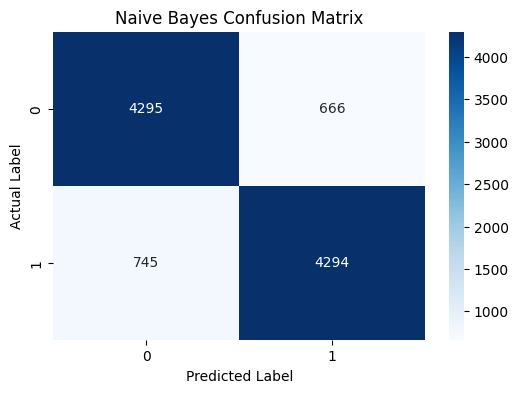

In [37]:
cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues")
plt.title('Naive Bayes Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

### Confusion matrix for Logistic Regression

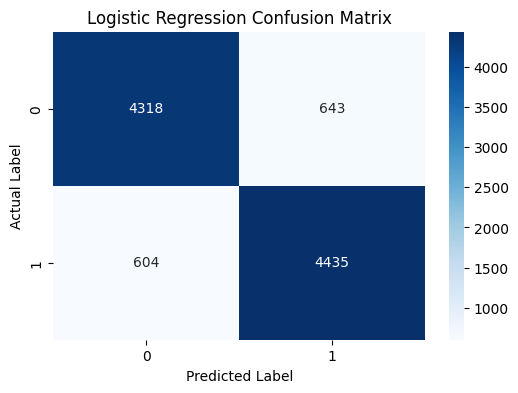

In [38]:
cm_log = confusion_matrix(y_test, y_pred_log)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_log, annot=True, fmt="d", cmap="Blues")
plt.title('Logistic Regression Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

### Confusion matrix for Random Forest

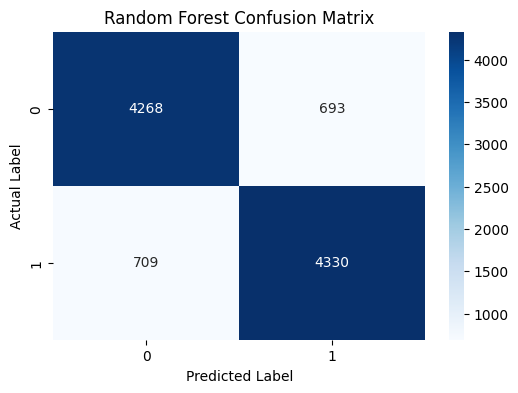

In [39]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues")
plt.title('Random Forest Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

### Confusion matrix for Decision Tree

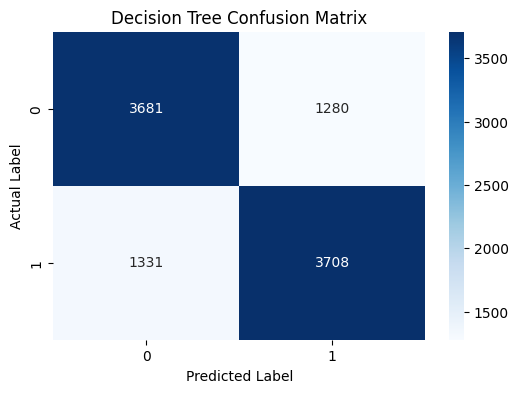

In [40]:
cm_tree = confusion_matrix(y_test, y_pred_tree)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_tree, annot=True, fmt="d", cmap="Blues")
plt.title('Decision Tree Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()



### Sentiment Classification Model Results

#### 1. Model Performance
- **Logistic Regression Accuracy**: 88.27%
- **Naive Bayes Accuracy**: 86.09%
- **Random Forest Accuracy**: 86.43%
- **Decision Tree Accuracy**: 74.00%

Logistic Regression achieved the best performance, with an accuracy of 88.27%, followed by Random Forest and Naive Bayes.

| Model              | Accuracy  |
|--------------------|-----------|
| Logistic Regression | 88.27%    |
| Naive Bayes         | 86.09%    |
| Random Forest       | 86.43%    |
| Decision Tree       | 74.00%    |

#### 2. Key Insights
- **Text Preprocessing**: Techniques such as cleaning text (removal of numbers, punctuation, and stop words) significantly improved the quality of the data.
- **TF-IDF Representation**: Helped highlight important words, minimizing the influence of frequently occurring, less meaningful terms.
- **Class Imbalance**: Slight class imbalance may have affected the performance of the Naive Bayes model.

#### 3. Challenges
- **Overfitting**: Certain models, particularly Decision Tree and Random Forest, showed signs of overfitting, which led to decreased generalization on unseen data.

#### 4. Conclusion
Logistic Regression provided the highest accuracy and demonstrated reliability for sentiment classification. Future improvements could involve hyperparameter tuning and feature engineering (such as incorporating bigrams or word embeddings) to boost model performance further.

# Create a Simple UI

Install the Required Libraries: First, install the required libraries for packaging and creating the UI.

#### Install Required Libraries

In [ ]:
pip install ipywidgets joblib

Note: you may need to restart the kernel to use updated packages.


#### Import Necessary Libraries

In [41]:
import joblib
import numpy as np
import ipywidgets as widgets
from IPython.display import display
from sklearn.feature_extraction.text import TfidfVectorizer


#### Function to Predict Sentiment
Create a function that will predict the sentiment based on the selected model and the user’s input:

In [ ]:
def predict_sentiment(review, model_choice):
    # Transform the input review using the vectorizer
    review_vector = vectorizer.transform([review])

    # Predict based on the selected model
    if model_choice == "Logistic Regression":
        model = log_reg
    elif model_choice == "Naive Bayes":
        model = nb_model
    elif model_choice == "Random Forest":
        model = rf_model
    elif model_choice == "Decision Tree":
        model = tree_model

    # Make the prediction
    prediction = model.predict(review_vector)
    probability = model.predict_proba(review_vector)

    sentiment = "Positive" if prediction[0] == 1 else "Negative"
    confidence = np.max(probability)

    return sentiment, confidence


#### Create the UI with Widgets
Now, you will create an interactive UI using ipywidgets:

In [ ]:
# Text area with custom layout
review_input = widgets.Textarea(
    value='',
    placeholder='Type your movie review here...',
    description='Review:',
    layout=widgets.Layout(width='100%', height='150px', border='2px solid black', padding='10px')
)

# Dropdown with improved styling
model_dropdown = widgets.Dropdown(
    options=['Logistic Regression', 'Naive Bayes', 'Random Forest', 'Decision Tree'],
    value='Logistic Regression',
    description='Model:',
    disabled=False,
    layout=widgets.Layout(width='50%', padding='5px')
)

# Submit button with custom style
submit_button = widgets.Button(
    description="Predict Sentiment",
    button_style='success',  # Colors: 'success', 'info', 'warning', 'danger' for styling
    layout=widgets.Layout(width='30%', padding='10px'),
    icon='check'  # Add icon
)

# Output area with styled border
output = widgets.Output(layout={'border': '2px solid green', 'padding': '10px'})

# Display the styled widgets
display(review_input, model_dropdown, submit_button, output)


### 6. How the Code Works
**Text Area (review_input):** This allows the user to type in their movie review.

**Dropdown (model_dropdown):** Lets the user select which model they want to use for the sentiment prediction.

**Submit Button (submit_button):** When clicked, it triggers the prediction function.

**Output Area (output):** Displays the result (sentiment and confidence score).

**Event Handler (on_submit_clicked):** This function gets called when the button is clicked. It reads the review, calls predict_sentiment(), and displays the result.

#### Adding Error Handling
To ensure a smoother user experience, we can add error handling for invalid inputs (like empty reviews). We will also add informative messages when input is not provided.

Here’s how you can improve the error handling:

In [ ]:
# Enhanced function to handle invalid inputs and prediction
def on_submit_clicked(b):
    with output:
        output.clear_output()  # Clear previous output
        review = review_input.value.strip()  # Remove extra spaces
        selected_model = model_dropdown.value

        if not review:
            display("⚠️ Please enter a review before submitting.")
            return

        try:
            # Predict the sentiment
            sentiment, confidence = predict_sentiment(review, selected_model)
            display(f"✅ Sentiment: **{sentiment}** with confidence: {confidence:.2f}")
        except Exception as e:
            display(f"❌ Error: {e}")


In [ ]:
pip install streamlit

## Set Up the Models and Save Them:

Save the trained models using joblib or pickle to later load them in the UI.

In [42]:
import joblib

# Save models
joblib.dump(log_reg, 'logistic_regression_model.pkl')
joblib.dump(nb_model, 'naive_bayes_model.pkl')
joblib.dump(rf_model, 'random_forest_model.pkl')
joblib.dump(tree_model, 'decision_tree_model.pkl')



['decision_tree_model.pkl']

In [43]:
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

#### Load the Pre-trained Models and TF-IDF Vectorizer

In [ ]:
# Load the saved models
log_reg = joblib.load('logistic_regression_model.pkl')
nb_model = joblib.load('naive_bayes_model.pkl')
rf_model = joblib.load('random_forest_model.pkl')
tree_model = joblib.load('decision_tree_model.pkl')

# Load the TF-IDF vectorizer
vectorizer = joblib.load('tfidf_vectorizer.pkl')


## Create the Streamlit App:

In [ ]:
import streamlit as st
import joblib
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the trained models and TF-IDF vectorizer
model = joblib.load('logistic_regression_model.pkl')
model = joblib.load(nb_model, 'naive_bayes_model.pkl')
model = joblib.load(rf_model, 'random_forest_model.pkl')
model = joblib.load(tree_model, 'decision_tree_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')

# Define a function to predict sentiment
def predict_sentiment(review):
    review_vector = vectorizer.transform([review])
    prediction = model.predict(review_vector)
    probability = model.predict_proba(review_vector)
    return prediction[0], np.max(probability)

# Streamlit UI
st.title("Movie Reviews Sentiment Analysis")
st.write("Enter a movie review and get its sentiment classified as Positive or Negative.")

# Text input
user_input = st.text_area("Enter your movie review:")

if st.button("Predict Sentiment"):
    if user_input:
        sentiment, confidence = predict_sentiment(user_input)
        if sentiment == 1:
            st.success(f"The review is **Positive** with a confidence of {confidence:.2f}")
        else:
            st.error(f"The review is **Negative** with a confidence of {confidence:.2f}")
    else:
        st.write("Please enter a review to analyze.")



Overwriting app.py


In [ ]:
!pip install streamlit pyngrok

In [ ]:
%%writefile app.py
import streamlit as st
st.title('My Streamlit App')
st.write("This is a simple Streamlit app running in Colab!")

Overwriting app.py


In [ ]:
import streamlit as st
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
import re

# Load the models
log_reg = joblib.load('logistic_regression_model.pkl')
nb_model = joblib.load('naive_bayes_model.pkl')
rf_model = joblib.load('random_forest_model.pkl')
tree_model = joblib.load('decision_tree_model.pkl')

# Load the TF-IDF vectorizer
vectorizer = joblib.load('tfidf_vectorizer.pkl')

# Preprocessing function
def preprocess_text(text):
    # Same preprocessing steps you used before training
    text = re.sub(r'[^\w\s]', '', text.lower())
    return text

# Set up the Streamlit app
st.title("Sentiment Analysis of Movie Reviews")

# Input text for sentiment analysis
user_input = st.text_area("Enter a movie review")

# Dropdown for selecting the model
model_choice = st.selectbox("Choose a model", ("Logistic Regression", "Naive Bayes", "Random Forest", "Decision Tree"))

# Predict sentiment
if st.button("Analyze Sentiment"):
    if user_input:
        # Preprocess the input text
        cleaned_text = preprocess_text(user_input)
        transformed_text = vectorizer.transform([cleaned_text])

        # Make predictions based on the selected model
        if model_choice == "Logistic Regression":
            prediction = log_reg.predict(transformed_text)[0]
        elif model_choice == "Naive Bayes":
            prediction = nb_model.predict(transformed_text)[0]
        elif model_choice == "Random Forest":
            prediction = rf_model.predict(transformed_text)[0]
        else:
            prediction = tree_model.predict(transformed_text)[0]

        # Display the result
        sentiment = "Positive" if prediction == 1 else "Negative"
        st.write(f"Predicted Sentiment: **{sentiment}**")
    else:
        st.write("Please enter a review.")


2024-10-14 12:36:56.251 
  command:

    streamlit run C:\Users\marke\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py [ARGUMENTS]


## Run Streamlit in Google Colab:

In [ ]:
from pyngrok import ngrok

# Start a Streamlit app
!streamlit run app.py &

# Open a public URL using ngrok
public_url = ngrok.connect(port='8501')
public_url


OSError: Background processes not supported.

## Save and Load the TF-IDF Vectorizer:

Along with the models, you also need to save the TfidfVectorizer to ensure the input text is transformed similarly to when the models were trained.

In [ ]:
# joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
